In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Baca dataset
df = pd.read_excel('dataset_clean_2018-2023.xlsx')

In [3]:
# Konversi kolom 'Harga' menjadi numerik
df['Harga'] = pd.to_numeric(df['Harga'], errors='coerce').astype('int64')

In [4]:
# Skala data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Harga_scaled'] = scaler.fit_transform(df['Harga'].values.reshape(-1, 1))

In [5]:
# Buat urutan data untuk Random Forest
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [6]:
# Parameter
seq_length = 2  # Panjang urutan

In [7]:
# Dictionary untuk menyimpan model, scaler, data uji, dan feature importances tiap provinsi
models_rf = {}
scalers_rf = {}
test_data_dict = {}
feature_importances_dict = {}

In [8]:
# Loop untuk melatih model tiap provinsi
for provinsi in df['Nama Provinsi'].unique():
    provinsi_data = df[df['Nama Provinsi'] == provinsi]['Harga_scaled'].values
    
    if len(provinsi_data) < seq_length + 1:
        print(f"Skipping {provinsi} due to insufficient data.")
        continue
    
    # Buat urutan data untuk Random Forest
    x, y = create_sequences(provinsi_data, seq_length)
    
    # Pisahkan data menjadi set pelatihan dan pengujian
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    
    # Latih model Random Forest
    model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
    model_rf.fit(x_train, y_train)
    
    # Simpan model dan scaler
    models_rf[provinsi] = model_rf
    scalers_rf[provinsi] = scaler
    
    # Simpan data uji dan feature importances
    test_data_dict[provinsi] = y_test
    feature_importances_dict[provinsi] = model_rf.feature_importances_

print("Model training completed.")

Model training completed.


In [9]:
# Fungsi untuk menampilkan data uji
def show_test_data(provinsi):
    if provinsi in test_data_dict:
        print(f"Test data for {provinsi}:")
        print(test_data_dict[provinsi])
    else:
        print(f"No test data found for {provinsi}.")


In [10]:
# Contoh penggunaan fungsi untuk menampilkan data uji provinsi tertentu
show_test_data('Sumatera Barat')
show_test_data('Bali')

Test data for Sumatera Barat:
[0.85146399 0.83436632 0.83276341 0.83222911 0.83436632 0.82314597
 0.83810643 0.88886514 0.88993375 0.87497328 0.88619363 0.90435991
 0.92573199 0.92840351 0.91397735]
Test data for Bali:
[0.70079077 0.71147681 0.71147681 0.71147681 0.70239367 0.70559949
 0.74727506 0.78841633 0.80070528 0.79375935 0.79482795 0.81833725
 0.89634537 0.86215003 0.8311605 ]


In [11]:
# Fungsi untuk memplot feature importances untuk satu provinsi
def plot_feature_importances(provinsi):
    if provinsi in feature_importances_dict:
        importances = feature_importances_dict[provinsi]
        plt.figure()
        plt.bar(range(len(importances)), importances, label=f"{provinsi} Feature Importances")
        plt.title(f"Feature Importances for {provinsi}")
        plt.xlabel("Feature Index")
        plt.ylabel("Importance")
        plt.legend()
        plt.show()
    else:
        print(f"No feature importances found for {provinsi}.")

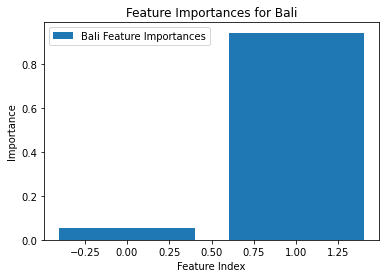

In [12]:
# Contoh penggunaan fungsi untuk memplot feature importances untuk provinsi tertentu
plot_feature_importances('Bali')

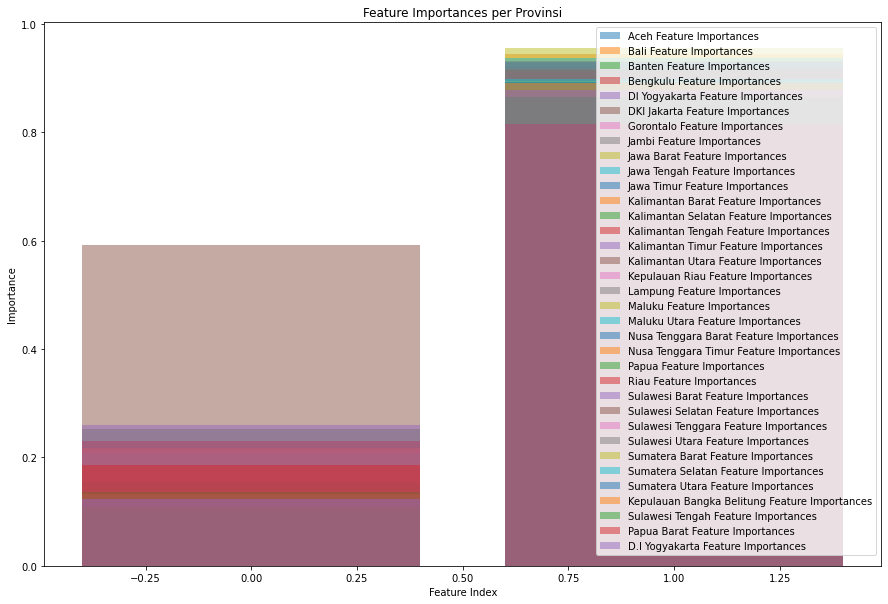

In [13]:
# Plot feature importances untuk setiap provinsi
plt.figure(figsize=(15, 10))
for provinsi, importances in feature_importances_dict.items():
    plt.bar(range(len(importances)), importances, alpha=0.5, label=f"{provinsi} Feature Importances")

plt.title("Feature Importances per Provinsi")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.legend()
plt.show()

In [14]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

In [15]:
# Dictionary untuk menyimpan metrik evaluasi tiap provinsi
metrics_rf_dict = {}

In [16]:
# Loop untuk menghitung metrik evaluasi tiap provinsi
for provinsi in df['Nama Provinsi'].unique():
    if provinsi not in models_rf:
        print(f"No model found for {provinsi}. Skipping evaluation.")
        continue
    
    # Ambil model dan scaler untuk provinsi ini
    model_rf = models_rf[provinsi]
    scaler = scalers_rf[provinsi]
    
    # Ambil data uji
    provinsi_data = df[df['Nama Provinsi'] == provinsi]['Harga_scaled'].values
    x, y = create_sequences(provinsi_data, seq_length)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    
    # Prediksi nilai
    y_pred = model_rf.predict(x_test)
    
    # Balikkan skala nilai prediksi dan nilai sebenarnya
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Hitung metrik evaluasi
    rmse, mape, r2 = calculate_metrics(y_test, y_pred)
    metrics_rf_dict[provinsi] = {'RMSE': rmse, 'MAPE': mape, 'R-Squared': r2, 'y_true': y_test, 'y_pred': y_pred}
    
    print(f"Metrics for {provinsi}: RMSE = {rmse}, MAPE = {mape}%, R-Squared = {r2}")

Metrics for Aceh: RMSE = 1491.1231131108316, MAPE = 8.325934430172023%, R-Squared = -1.9670133261215414
Metrics for Bali: RMSE = 2290.5673422509685, MAPE = 12.903845380024274%, R-Squared = -2.9245376973127812
Metrics for Banten: RMSE = 2186.2091713953905, MAPE = 10.515191120176267%, R-Squared = -1.7061839471149116
Metrics for Bengkulu: RMSE = 2061.530860068157, MAPE = 10.260866352326202%, R-Squared = -1.9404934001714818
Metrics for DI Yogyakarta: RMSE = 148.3397841668455, MAPE = 0.9460017754293504%, R-Squared = 0.6811282688352888
Metrics for DKI Jakarta: RMSE = 2028.776683863131, MAPE = 9.320337877789846%, R-Squared = -0.5380871304563073
Metrics for Gorontalo: RMSE = 2648.1441435893644, MAPE = 14.136402774743464%, R-Squared = -2.051365598708472
Metrics for Jambi: RMSE = 1713.9382229629273, MAPE = 9.55515490206614%, R-Squared = -2.164006136134931
Metrics for Jawa Barat: RMSE = 2010.617838695362, MAPE = 9.369439003866493%, R-Squared = -1.383234381813689
Metrics for Jawa Tengah: RMSE = 18

In [17]:
# Contoh penggunaan untuk menampilkan metrik evaluasi provinsi tertentu
provinsi_to_check = 'Kalimantan Barat'
if provinsi_to_check in metrics_rf_dict:
    metrics = metrics_rf_dict[provinsi_to_check]
    print(f"Metrics for {provinsi_to_check}: RMSE = {metrics['RMSE']}, MAPE = %{metrics['MAPE']}, R-Squared = {metrics['R-Squared']}")
else:
    print(f"No metrics found for {provinsi_to_check}.")

Metrics for Kalimantan Barat: RMSE = 2190.6008969291215, MAPE = %12.12313267784971, R-Squared = -4.210510857451989


In [18]:
# Fungsi untuk menampilkan hasil prediksi dan nilai sebenarnya
def plot_predictions(provinsi):
    if provinsi in metrics_rf_dict:
        y_true = metrics_rf_dict[provinsi]['y_true']
        y_pred = metrics_rf_dict[provinsi]['y_pred']
        
        plt.figure(figsize=(10, 6))
        plt.plot(y_true, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"Actual vs Predicted Prices for {provinsi}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
    else:
        print(f"No results found for {provinsi}.")

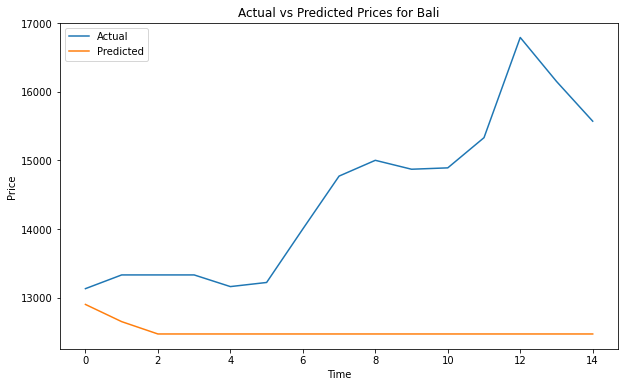

In [19]:
# Contoh penggunaan untuk menampilkan prediksi dan nilai sebenarnya provinsi tertentu
provinsi_to_check = 'Bali'
plot_predictions(provinsi_to_check)

In [20]:
# Gabungkan semua hasil prediksi dan nilai sebenarnya ke dalam satu DataFrame dengan tanggal
results_rf = []
for provinsi in metrics_rf_dict:
    y_true = metrics_rf_dict[provinsi]['y_true']
    y_pred = metrics_rf_dict[provinsi]['y_pred']
    test_dates = df[df['Nama Provinsi'] == provinsi].iloc[-len(y_true):]['Tanggal'].values
    for i in range(len(y_true)):
        results_rf.append([provinsi, test_dates[i], i+1, y_true[i], y_pred[i]])

In [21]:
# Buat DataFrame dari hasil prediksi dan nilai sebenarnya
results_rf_df = pd.DataFrame(results_rf, columns=['Provinsi', 'Tanggal', 'Index', 'Harga Sebenarnya', 'Prediksi Harga'])

In [22]:
# Simpan DataFrame ke file Excel
# output_file_rf = 'prediksi_harga_beras_rf.xlsx'
# with pd.ExcelWriter(output_file_rf) as writer:
#     results_rf_df.to_excel(writer, index=False, sheet_name='Prediksi vs Harga Sebenarnya RF')

# print(f"Hasil prediksi dan nilai sebenarnya telah disimpan ke {output_file_rf}.")

In [23]:
# Fungsi untuk melakukan prediksi 12 bulan ke depan
def predict_future(provinsi, model, scaler, start_date, periods=12):
    # Ambil data terakhir untuk membuat prediksi
    provinsi_data = df[df['Nama Provinsi'] == provinsi]['Harga_scaled'].values
    last_sequence = provinsi_data[-seq_length:]
    
    # Simpan hasil prediksi
    predictions = []
    current_sequence = last_sequence.reshape(1, -1)
    
    for i in range(periods):
        # Prediksi bulan berikutnya
        next_pred = model.predict(current_sequence)
        
        # Simpan hasil prediksi
        predictions.append(next_pred[0])
        
        # Perbarui urutan data dengan menambahkan prediksi baru
        current_sequence = np.append(current_sequence[:, 1:], next_pred)
        current_sequence = current_sequence.reshape(1, -1)
    
    # Balikkan skala hasil prediksi
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    
    # Buat daftar tanggal untuk 12 bulan ke depan
    dates = pd.date_range(start=start_date, periods=periods, freq='MS')
    
    return dates, predictions

In [24]:
# Dictionary untuk menyimpan hasil prediksi tiap provinsi
future_predictions = {}

In [25]:
# Mulai prediksi dari April 2023
start_date = '2023-04-01'

In [26]:
# Loop untuk melakukan prediksi 12 bulan ke depan tiap provinsi
for provinsi in models_rf:
    model_rf = models_rf[provinsi]
    scaler_rf = scalers_rf[provinsi]
    dates, predictions = predict_future(provinsi, model_rf, scaler_rf, start_date)
    future_predictions[provinsi] = {'dates': dates, 'predictions': predictions}

print("Future predictions completed.")

Future predictions completed.


In [27]:
# Fungsi untuk menampilkan hasil prediksi 12 bulan ke depan
def plot_future_predictions(provinsi):
    if provinsi in future_predictions:
        dates = future_predictions[provinsi]['dates']
        predictions = future_predictions[provinsi]['predictions']
        
        plt.figure(figsize=(10, 6))
        plt.plot(dates, predictions, label='Future Predictions')
        plt.title(f"Future Predictions for {provinsi}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
    else:
        print(f"No future predictions found for {provinsi}.")

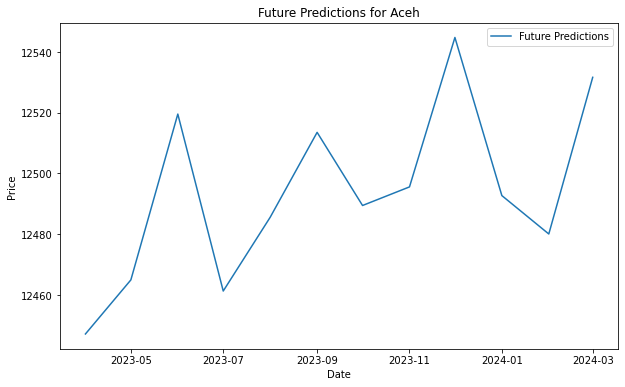

In [28]:
# Contoh penggunaan untuk menampilkan prediksi 12 bulan ke depan provinsi tertentu
provinsi_to_check = 'Aceh'
plot_future_predictions(provinsi_to_check)

In [29]:
# Gabungkan semua hasil prediksi ke dalam satu DataFrame
results_future = []
for provinsi in future_predictions:
    dates = future_predictions[provinsi]['dates']
    predictions = future_predictions[provinsi]['predictions']
    for date, pred in zip(dates, predictions):
        results_future.append([provinsi, date, pred])

In [30]:
# Buat DataFrame dari hasil prediksi
results_future_df = pd.DataFrame(results_future, columns=['Provinsi', 'Tanggal', 'Prediksi Harga'])

In [31]:
# Simpan DataFrame ke file Excel
# output_file_future = 'prediksi_harga_beras_12_bulan_rf.xlsx'
# with pd.ExcelWriter(output_file_future) as writer:
#     results_future_df.to_excel(writer, index=False, sheet_name='Prediksi 12 Bulan ke Depan RF')

# print(f"Hasil prediksi 12 bulan ke depan telah disimpan ke {output_file_future}.")

In [32]:
for provinsi in df['Nama Provinsi'].unique():
    provinsi_data = df[df['Nama Provinsi'] == provinsi]['Harga'].values
    print(f'{provinsi} - Data Points: {len(provinsi_data)}')

Aceh - Data Points: 76
Bali - Data Points: 76
Banten - Data Points: 76
Bengkulu - Data Points: 76
DI Yogyakarta - Data Points: 60
DKI Jakarta - Data Points: 76
Gorontalo - Data Points: 76
Jambi - Data Points: 76
Jawa Barat - Data Points: 76
Jawa Tengah - Data Points: 76
Jawa Timur - Data Points: 76
Kalimantan Barat - Data Points: 76
Kalimantan Selatan - Data Points: 76
Kalimantan Tengah - Data Points: 76
Kalimantan Timur - Data Points: 76
Kalimantan Utara - Data Points: 76
Kepulauan Riau - Data Points: 76
Lampung - Data Points: 76
Maluku - Data Points: 76
Maluku Utara - Data Points: 76
Nusa Tenggara Barat - Data Points: 76
Nusa Tenggara Timur - Data Points: 76
Papua - Data Points: 76
Riau - Data Points: 76
Sulawesi Barat - Data Points: 76
Sulawesi Selatan - Data Points: 76
Sulawesi Tenggara - Data Points: 76
Sulawesi Utara - Data Points: 76
Sumatera Barat - Data Points: 76
Sumatera Selatan - Data Points: 76
Sumatera Utara - Data Points: 76
Kepulauan Bangka Belitung - Data Points: 75
Su

In [33]:
for provinsi in df['Nama Provinsi'].unique():
    provinsi_data = df[df['Nama Provinsi'] == provinsi]['Harga'].values
    print(f'{provinsi} - Mean: {np.mean(provinsi_data)}, Std: {np.std(provinsi_data)}, Min: {np.min(provinsi_data)}, Max: {np.max(provinsi_data)}')


Aceh - Mean: 12554.552631578947, Std: 762.6852560929023, Min: 11740, Max: 14620
Bali - Mean: 12407.342105263158, Std: 1209.6203248674396, Min: 11392, Max: 16790
Banten - Mean: 12014.315789473685, Std: 1184.9966379091359, Min: 10952, Max: 16710
Bengkulu - Mean: 12517.78947368421, Std: 1078.881515320252, Min: 11457, Max: 16010
DI Yogyakarta - Mean: 11711.233333333334, Std: 551.8019380981631, Min: 10984, Max: 13100
DKI Jakarta - Mean: 12946.842105263158, Std: 1035.6628191980496, Min: 12000, Max: 17420
Gorontalo - Mean: 12129.763157894737, Std: 1354.5475635061894, Min: 11073, Max: 17540
Jambi - Mean: 12753.052631578947, Std: 944.2768730724006, Min: 11638, Max: 15580
Jawa Barat - Mean: 12249.0, Std: 1053.070035657648, Min: 11420, Max: 16640
Jawa Tengah - Mean: 12215.421052631578, Std: 1070.710330662951, Min: 11242, Max: 16260
Jawa Timur - Mean: 12079.723684210527, Std: 1048.221759867687, Min: 11154, Max: 15850
Kalimantan Barat - Mean: 14180.947368421053, Std: 1099.6738499106384, Min: 12000,